In [ ]:
#Import required libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import shutil
from tensorflow.keras.applications.vgg16 import preprocess_input
from pathlib import Path
from sklearn.metrics import classification_report, roc_auc_score, f1_score, precision_score, recall_score
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16, ResNet50, ResNet101, EfficientNetB0


**I. Data Loading**

In [ ]:
# Step 1: Mount Google Drive to access files stored in Drive account
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Step 2: Define the path to the dataset stored in Google Drive
# The dataset should be placed inside a folder named 'data' under MyDrive, with subfolder 'RealWaste'
# Each subfolder within 'RealWaste' corresponds to one waste class (e.g., '1-Cardboard')
base_dir = '/content/drive/MyDrive/data/RealWaste'

In [ ]:
# Step 3: Define key parameters for preprocessing and model input
IMG_SIZE = (224, 224)  # All images will be resized to 224x224 pixels to match pretrained model input size
BATCH_SIZE = 16         # Number of images processed together in a single training step
SEED = 42              # Random seed to ensure consistent data splits across runs

Step 4: Manually Split dataset into train, validation, and test sets by copying images. First 80% = training and last 20% is test. Procedure:
1. Read class folders from dataset root. Sub-folders represent class labels, e.g., 1-Cardboard, etc.

Iterate over each class folder:
2. Sort all image filenames, ensures consistent ordering so that the first 80% selection is deterministic.

3. Compute dataset splts: 20% and 80%: Training + Validation of which 20% if validation. Thus, 64% = Train, 16% = validatoin, 20% = test.

4. Copy images into new directory structure (in memory in colab). Creates 3 folders: train, test, val and 9 sub-folders within each of these 3 folders


5. Use shutil.copy to move files: physically copies image files into the new locations.



In [ ]:
# Step 4: Manually split dataset into train, validation, and test sets by copying images
import shutil
from pathlib import Path

def prepare_split_folders(src_root, dst_root, train_ratio=0.8, val_ratio=0.2):
    # List all class folders inside the dataset directory and sort them alphabetically
    classes = sorted(os.listdir(src_root))

    # Iterate over each class folder (e.g., 1-Cardboard, 2-Food Organics)
    for class_name in classes:
        src_folder = os.path.join(src_root, class_name)  # e.g., /content/drive/.../RealWaste/1-Cardboard
        images = sorted(os.listdir(src_folder))  # Get all image filenames in sorted order
        total = len(images)  # Total number of images in this class

        # Calculate how many images go into each split
        train_end = int(train_ratio * total)  # 80% of images
        val_end = int(train_end * val_ratio)  # 20% of training images become validation set

        # Create train, val, test splits by index slicing
        train_imgs = images[:train_end - val_end]  # First 64%
        val_imgs = images[train_end - val_end:train_end]  # Next 16%
        test_imgs = images[train_end:]  # Remaining 20%

        # Copy images to appropriate split directories
        for split, split_imgs in zip(['train', 'val', 'test'], [train_imgs, val_imgs, test_imgs]):
            split_dir = os.path.join(dst_root, split, class_name)  # e.g., /content/split_data/train/1-Cardboard
            os.makedirs(split_dir, exist_ok=True)  # Make sure the directory exists
            for img in split_imgs:
                shutil.copy(os.path.join(src_folder, img), os.path.join(split_dir, img))  # Copy file

# Call the function to split the dataset and create the directory structure
# /content/split_data/train/, /val/, /test/, each with class subfolders inside them
prepare_split_folders(base_dir, '/content/split_data')

**II. Data Preprocessing**

We use the tf.data API to load and preprocess image data efficiently. Images are batched and resized to (224, 224) during loading, then cached and prefetched to enable fast, parallelized data feeding on GPU. A built-in augmentation pipeline applies random flips, rotations, zooms, and translations during training to improve generalization. Validation and test datasets are only normalized to ensure fair evaluation.

Steps:
1. Integrated Data Augmentation Layer (GPU-accelerated)
- A sequential augmentation pipeline (flip, rotate, zoom, contrast, crop, translate) is applied on the GPU during training.
- Purpose: Increases variability and helps the model generalize better by preventing overfitting.

2. Load Datasets Using tf.data API
- Datasets are loaded from folder structures, with automatic labeling based on directory names.
- Training data is shuffled and batched; validation and test sets are not shuffled to ensure consistent evaluation.
- Caching and prefetching are applied to all datasets to minimize disk access and maximize GPU throughput.
- Note: Augmentation is applied later during model execution, not at the loading stage.

3. Extract Class Names and Optimize Pipeline
- Class names are extracted from the training directory to determine the number of output classes.
- The dataset is then cached, shuffled, and prefetched to optimize performance.
- Purpose: Supports dynamic configuration of the model’s output layer and efficient training.



In [ ]:
# Step 1 Integrated data augmentation layer (runs on GPU)
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.RandomCrop(height=IMG_SIZE[0], width=IMG_SIZE[1]),
    tf.keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2)
])

# === Load datasets using tf.data API ===

In [ ]:
# Step 2: Load datasets using tf.data API
AUTOTUNE = tf.data.AUTOTUNE

raw_train_dataset = tf.keras.utils.image_dataset_from_directory(
    '/content/split_data/train',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical',  # One-hot encoded labels
    shuffle=True,
    seed=SEED
)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    '/content/split_data/val',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    shuffle=False
).cache().prefetch(buffer_size=AUTOTUNE)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    '/content/split_data/test',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    shuffle=False
).cache().prefetch(buffer_size=AUTOTUNE)

# Step 3. Extract class names before applying .cache/.shuffle/.prefetch
class_names = raw_train_dataset.class_names
num_classes = len(class_names)

# Apply cache, shuffle, and prefetch to training dataset
train_dataset = raw_train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)


Found 3042 files belonging to 9 classes.
Found 756 files belonging to 9 classes.
Found 954 files belonging to 9 classes.


**III. Model training and evaluation.**

As first step we will define utility functions that we can re-use for the different models we will be using.

**Utility Function #1:** to plot training & validation history. This function visualizes the training progress of model by plotting:

  A. Training vs. Validation Accuracy over epochs.

  B. Traning vs. Validation Loss over epochs.

It uses the history object returned by model.fit() — which contains logged metrics like 'accuracy', 'val_accuracy', 'loss', and 'val_loss'.


In [ ]:
def plot_training_history(history):
    """
    Plots the training and validation accuracy and loss over epochs.
    Useful for visualizing model convergence and detecting overfitting/underfitting.
    Args: history: Keras History object returned by model.fit(), containing loss and accuracy metrics.
    """
    # Create a side-by-side plot for accuracy and loss
    plt.figure(figsize=(12, 4))

    # Plot training and validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.tight_layout()
    plt.show()


**Utility Function #2**: Trains models with following steps:

1. Load Base Model
- Use a pretrained model from keras.applications (e.g., ResNet101, EfficientNetB0)
- Set include_top=False to exclude the original classification layer
- Set weights='imagenet' to initialize with pretrained ImageNet weights
- Set trainable=False to freeze all layers and use the model as a fixed feature extractor

2. Add a Custom Classification Head
- Since our dataset has 9 classes (not 1000), we replace the original head with a custom one:
- Apply Flatten or GlobalAveragePooling2D to convert convolutional output to a 1D vector
- Use BatchNormalization to stabilize learning and speed up convergence
- Add a Dense(256, activation='relu') layer with L2 regularization to learn non-linear combinations of extracted features
- Add Dropout(0.2) to prevent overfitting
- End with a Dense(num_classes, activation='softmax') layer to output class probabilities

3. Compile the Model

- Optimizer: Adam(learning_rate=1e-4) for stable and efficient updates
- Loss: categorical_crossentropy, suitable for one-hot encoded multi-class labels
- Metrics: accuracy to track classification performance

4. Define Callbacks

- EarlyStopping to halt training if val_loss does not improve for 5 epochs, restoring the best weights
- ModelCheckpoint to save the model with the lowest validation loss (save_best_only=True)

5. Train the Model

- Train using model.fit() on the preprocessed training and validation datasets
- Run for up to 100 epochs, with early stopping in place to avoid overfitting
- Return the trained model and its history for further evaluation or visualizatio

In [ ]:
# === Modular Transfer Learning Training Function ===

def train_model(base_model_fn, model_name, train_generator, val_generator, input_shape=(224, 224, 3), num_classes_override=None):
    """
    Trains a transfer learning model using a frozen base model and custom head.

    Args:
        base_model_fn: Callable that returns a Keras base model (e.g., VGG16, ResNet50)
        model_name: String used to name the saved model file
        train_generator: ImageDataGenerator for training images
        val_generator: ImageDataGenerator for validation images
        input_shape: Input shape expected by the base model (default is (224, 224, 3))
        num_classes_override: Required number of output classes (used to define final Dense layer)

    Returns:
        model: Trained Keras model
        history: History object containing training metrics
    """

    if num_classes_override is not None:
        num_classes_final = num_classes_override
    else:
        raise ValueError("You must specify num_classes_override when using tf.data datasets.")

    # Step 1. Load base model (e.g., VGG16, ResNet50) without the top layer
    base_model = base_model_fn(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze base model

    #Step 2.  Build functional model
    inputs = tf.keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = preprocess_input(x)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(num_classes_final, activation='softmax')(x)
    model = models.Model(inputs, outputs)

    # Step 3. Compile the model
    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Step 4. Callbacks for early stopping and saving best model
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, start_from_epoch=10)
    checkpoint = ModelCheckpoint(f'best_{model_name}.keras', monitor='val_loss', save_best_only=True)

    # Step 5. Train the model
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=100,
        callbacks=[early_stop, checkpoint],
        verbose=1,
    )

    # Step 6. Plot training curves
    plot_training_history(history)

    # Identify and print the epoch with the best validation loss
    import numpy as np
    best_epoch = np.argmin(history.history['val_loss']) + 1
    best_val_loss = history.history['val_loss'][best_epoch - 1]
    print(f"✅ Best model saved from epoch {best_epoch} with val_loss = {best_val_loss:.4f}")

    return model, history

**Utility Function #3**: performs a comprehensive evaluation of a trained Keras model on the test set. SKey Operations:

1. Batch-wise Prediction and Label Extraction
- Iterates over the test_dataset to collect ground truth labels and model predictions batch by batch.
- Converts one-hot labels and softmax outputs to class indices for comparison.

2. Performance Metrics Computation
- Classification Report: Precision, Recall, and F1-score per class
- Macro-Averaged Metrics: Macro Precision, Recall, and F1 Score across all classes
- Multiclass AUC: One-vs-Rest AUC score computed using roc_auc_score on one-hot labels and softmax probabilities
- Test Accuracy: Overall percentage of correctly predicted labels

In [ ]:
def evaluate_model(model, test_dataset):
    """
    Evaluates a trained model on the test set using multiple metrics.
    - Iterates over batched tf.data.Dataset (no shuffling).
    - Computes predicted probabilities and class predictions.
    - Outputs classification report, precision, recall, F1 score, AUC, and accuracy.

    Args:
        model: Trained Keras model to evaluate.
        test_dataset: tf.data.Dataset for the test set (batched, prefetch, shuffle=False).
    """
    y_true = []  # Stores ground truth one-hot labels from test set
    y_pred_probs = []  # Stores model's softmax probabilities for each batch

    # Iterate over test dataset and accumulate predictions and true labels
    for batch_images, batch_labels in test_dataset:
        batch_preds = model.predict(batch_images, verbose=0)
        y_pred_probs.append(batch_preds)
        y_true.append(batch_labels)

    # Convert list of batches to full arrays
    y_true = np.concatenate(y_true)
    y_pred_probs = np.concatenate(y_pred_probs)

    # Convert softmax outputs to predicted class indices
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true_labels = np.argmax(y_true, axis=1)  # From one-hot to class index

    # Print classification metrics
    print("Test Classification Report:")
    print(classification_report(y_true_labels, y_pred, target_names=class_names))

    print("Test Precision:", precision_score(y_true_labels, y_pred, average='macro'))
    print("Test Recall:", recall_score(y_true_labels, y_pred, average='macro'))
    print("Test F1 Score:", f1_score(y_true_labels, y_pred, average='macro'))
    print("Test AUC:", roc_auc_score(y_true, y_pred_probs, multi_class='ovr'))
    print("Test Accuracy:", np.mean(y_pred == y_true_labels))

 We will NOW train and evaluate 4 models:
1. VGG16
2. ResNet50
3. ResNet100
4. EfficientNetB0

 =============================***1. VGG16 ***================================

Epoch 1/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 21s 87ms/step - accuracy: 0.2290 - loss: 5.6866 - val_accuracy: 0.4841 - val_loss: 4.7893
Epoch 2/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 17s 90ms/step - accuracy: 0.4788 - loss: 4.6571 - val_accuracy: 0.5992 - val_loss: 4.3317
Epoch 3/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 17s 88ms/step - accuracy: 0.5776 - loss: 4.2347 - val_accuracy: 0.6468 - val_loss: 4.0225
Epoch 4/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 16s 85ms/step - accuracy: 0.6220 - loss: 3.9430 - val_accuracy: 0.6720 - val_loss: 3.7723
Epoch 5/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 16s 84ms/step - accuracy: 0.6727 - loss: 3.6588 - val_accuracy: 0.6892 - val_loss: 3.5772
Epoch 6/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 16s 85ms/step - accuracy: 0.6886 - loss: 3.4797 - val_accuracy: 0.6971 - val_loss: 3.3825
Epoch 7/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 16s 86ms/step - accuracy: 0.7048 - loss: 3.2504 - val_accuracy: 0.7037 - val_loss: 3.2149
Epoch 8/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 16s 86ms/step - accuracy: 0.7234 - loss: 3

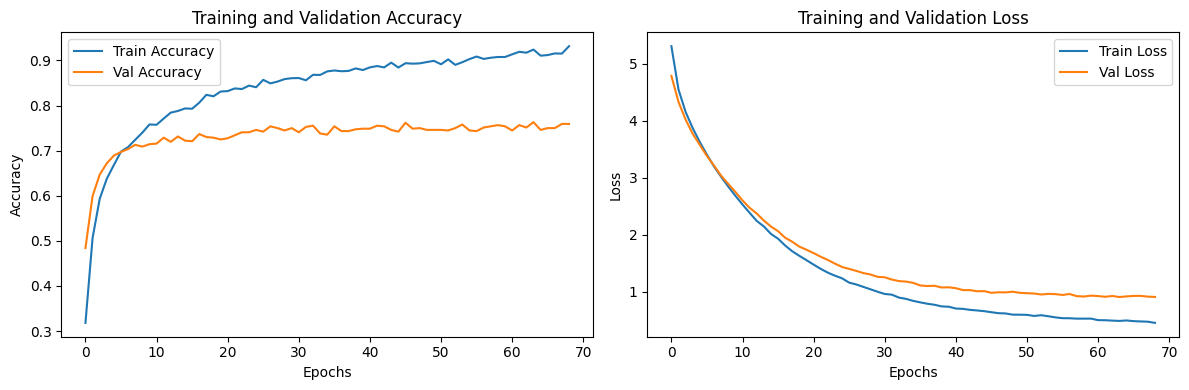

✅ Best model saved from epoch 64 with val_loss = 0.9085


In [ ]:

# === Train VGG16 using the modular function ===
model_vgg, history_vgg = train_model(
    base_model_fn=VGG16,
    model_name='vgg16_model',
    train_generator=train_dataset,
    val_generator=val_dataset,
    num_classes_override=num_classes
)



In [ ]:
# Step 7. Evaluate the trained VGG16 model outside the training function
evaluate_model(model_vgg, test_dataset)

Test Classification Report:
                       precision    recall  f1-score   support

          1-Cardboard       0.65      0.86      0.74        93
      2-Food Organics       0.73      0.88      0.80        83
              3-Glass       0.71      0.48      0.57        84
              4-Metal       0.74      0.85      0.79       158
5-Miscellaneous Trash       0.72      0.44      0.55        99
              6-Paper       0.92      0.77      0.84       100
            7-Plastic       0.70      0.80      0.75       185
      8-Textile Trash       0.76      0.61      0.68        64
         9-Vegetation       0.88      0.85      0.87        88

             accuracy                           0.75       954
            macro avg       0.76      0.73      0.73       954
         weighted avg       0.75      0.75      0.74       954

Test Precision: 0.7577334036957869
Test Recall: 0.7273829059674535
Test F1 Score: 0.7313291689834159
Test AUC: 0.9635076231238457
Test Accuracy: 0.745

 =============================***2. RESNET50 ***================================

Epoch 1/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 26s 99ms/step - accuracy: 0.3406 - loss: 6.4311 - val_accuracy: 0.6336 - val_loss: 5.3640
Epoch 2/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 17s 89ms/step - accuracy: 0.6900 - loss: 5.1809 - val_accuracy: 0.6892 - val_loss: 5.0126
Epoch 3/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 17s 88ms/step - accuracy: 0.7516 - loss: 4.7291 - val_accuracy: 0.7063 - val_loss: 4.7236
Epoch 4/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 17s 87ms/step - accuracy: 0.7867 - loss: 4.3349 - val_accuracy: 0.7354 - val_loss: 4.3931
Epoch 5/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 17s 87ms/step - accuracy: 0.8380 - loss: 3.9765 - val_accuracy: 0.7315 - val_loss: 4.1486
Epoch 6/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 17s 87ms/step - accuracy: 0.8246 - loss: 3.7143 - val_accuracy: 0.7354 - val_loss: 3.8484
Epoch 7/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 17s 88ms/step - accuracy: 0.8685 - loss: 3.3892 - val_accuracy: 0.7513 - val_loss: 3.6275
Epoch 8/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 17s 88ms/step - accuracy: 0.8900 - loss: 3

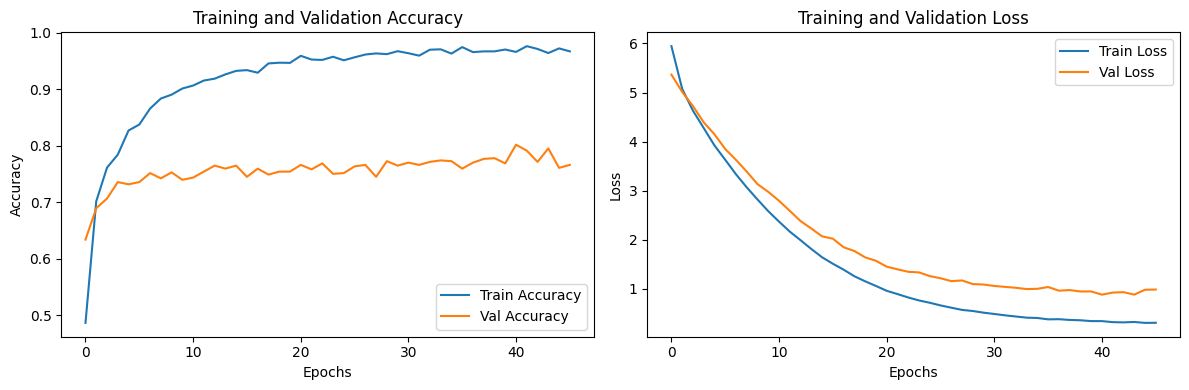

✅ Best model saved from epoch 41 with val_loss = 0.8827
Test Classification Report:
                       precision    recall  f1-score   support

          1-Cardboard       0.83      0.89      0.86        93
      2-Food Organics       0.82      0.86      0.84        83
              3-Glass       0.87      0.64      0.74        84
              4-Metal       0.69      0.92      0.79       158
5-Miscellaneous Trash       0.77      0.37      0.50        99
              6-Paper       0.91      0.90      0.90       100
            7-Plastic       0.79      0.79      0.79       185
      8-Textile Trash       0.73      0.70      0.71        64
         9-Vegetation       0.85      0.93      0.89        88

             accuracy                           0.79       954
            macro avg       0.80      0.78      0.78       954
         weighted avg       0.80      0.79      0.78       954

Test Precision: 0.8048799783080799
Test Recall: 0.7797864145494714
Test F1 Score: 0.7803705301

In [ ]:
# === Train ResNet50 using the modular function ===
model_resnet50, history_resnet50 = train_model(
    base_model_fn=ResNet50,
    model_name='resnet50_model',
    train_generator=train_dataset,
    val_generator=val_dataset,
    num_classes_override=num_classes
)

# === Evaluate the trained ResNet50 model ===
evaluate_model(model_resnet50, test_dataset)

 =============================***3. RESNET101 ***================================

Epoch 1/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 44s 165ms/step - accuracy: 0.3615 - loss: 6.4262 - val_accuracy: 0.6111 - val_loss: 5.4630
Epoch 2/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 27s 144ms/step - accuracy: 0.6718 - loss: 5.1891 - val_accuracy: 0.6799 - val_loss: 5.0792
Epoch 3/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 27s 142ms/step - accuracy: 0.7588 - loss: 4.7292 - val_accuracy: 0.6878 - val_loss: 4.7520
Epoch 4/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 27s 142ms/step - accuracy: 0.8077 - loss: 4.2908 - val_accuracy: 0.6825 - val_loss: 4.4976
Epoch 5/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 27s 143ms/step - accuracy: 0.8359 - loss: 3.9504 - val_accuracy: 0.7341 - val_loss: 4.1067
Epoch 6/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 27s 143ms/step - accuracy: 0.8474 - loss: 3.6484 - val_accuracy: 0.7421 - val_loss: 3.8679
Epoch 7/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 27s 143ms/step - accuracy: 0.8609 - loss: 3.3758 - val_accuracy: 0.7341 - val_loss: 3.6380
Epoch 8/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 27s 143ms/step - accuracy: 0.8744 -

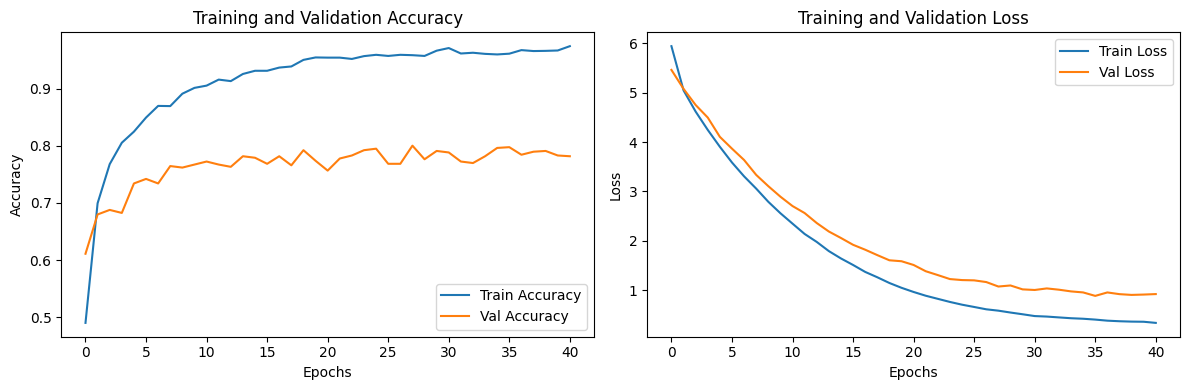

✅ Best model saved from epoch 36 with val_loss = 0.8850
Test Classification Report:
                       precision    recall  f1-score   support

          1-Cardboard       0.79      0.80      0.79        93
      2-Food Organics       0.84      0.75      0.79        83
              3-Glass       0.78      0.58      0.67        84
              4-Metal       0.70      0.90      0.79       158
5-Miscellaneous Trash       0.67      0.53      0.59        99
              6-Paper       0.91      0.90      0.90       100
            7-Plastic       0.76      0.82      0.79       185
      8-Textile Trash       0.82      0.62      0.71        64
         9-Vegetation       0.85      0.93      0.89        88

             accuracy                           0.78       954
            macro avg       0.79      0.76      0.77       954
         weighted avg       0.78      0.78      0.77       954

Test Precision: 0.7901371203326799
Test Recall: 0.7581157011526509
Test F1 Score: 0.7682774409

In [ ]:
# === Train ResNet101 using the modular function ===
model_resnet101, history_resnet101 = train_model(
    base_model_fn=ResNet101,
    model_name='resnet101_model',
    train_generator=train_dataset,
    val_generator=val_dataset,
    num_classes_override=num_classes
)

# === Evaluate the trained ResNet101 model ===
evaluate_model(model_resnet101, test_dataset)

 =============================***4. EfficientNetB0 ***================================

Epoch 1/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step - accuracy: 0.2775 - loss: 6.4192 - val_accuracy: 0.4854 - val_loss: 5.5344
Epoch 2/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - accuracy: 0.5239 - loss: 5.3337 - val_accuracy: 0.5304 - val_loss: 5.1651
Epoch 3/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - accuracy: 0.5920 - loss: 4.9013 - val_accuracy: 0.5661 - val_loss: 4.8888
Epoch 4/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - accuracy: 0.6240 - loss: 4.6176 - val_accuracy: 0.5873 - val_loss: 4.6548
Epoch 5/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - accuracy: 0.6793 - loss: 4.2263 - val_accuracy: 0.5860 - val_loss: 4.4341
Epoch 6/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - accuracy: 0.6824 - loss: 4.0251 - val_accuracy: 0.6045 - val_loss: 4.1516
Epoch 7/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - accuracy: 0.7212 - loss: 3.7139 - val_accuracy: 0.6045 - val_loss: 3.9702
Epoch 8/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - accuracy: 0.7083 - loss: 3

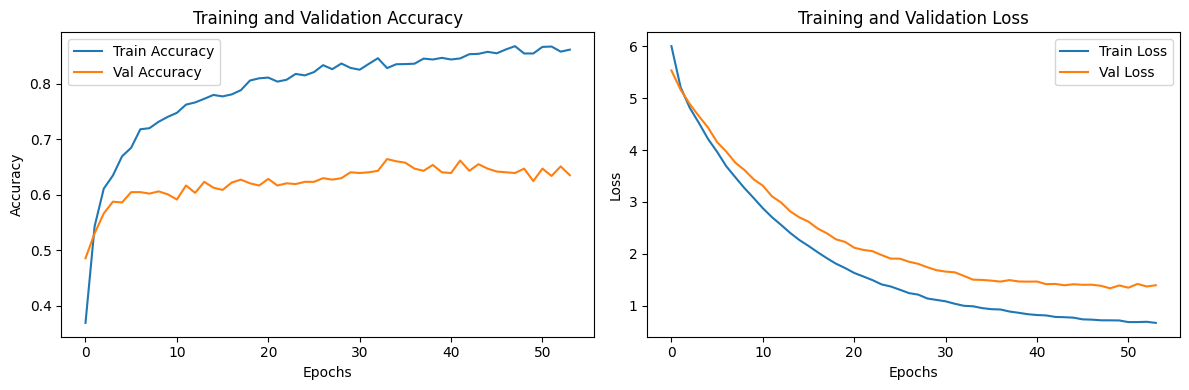

✅ Best model saved from epoch 49 with val_loss = 1.3330
Test Classification Report:
                       precision    recall  f1-score   support

          1-Cardboard       0.60      0.82      0.69        93
      2-Food Organics       0.61      0.90      0.73        83
              3-Glass       0.82      0.39      0.53        84
              4-Metal       0.76      0.74      0.75       158
5-Miscellaneous Trash       0.57      0.52      0.54        99
              6-Paper       0.89      0.82      0.85       100
            7-Plastic       0.79      0.82      0.80       185
      8-Textile Trash       0.77      0.56      0.65        64
         9-Vegetation       0.82      0.86      0.84        88

             accuracy                           0.73       954
            macro avg       0.74      0.71      0.71       954
         weighted avg       0.74      0.73      0.72       954

Test Precision: 0.7378605201201023
Test Recall: 0.7146318139868617
Test F1 Score: 0.7107075900

In [ ]:
# === Train EfficientNetB0 using the modular function ===
model_efficientnet, history_efficientnet = train_model(
    base_model_fn=EfficientNetB0,
    model_name='efficientnetb0_model',
    train_generator=train_dataset,
    val_generator=val_dataset,
    num_classes_override=num_classes
)

# === Evaluate the trained EfficientNetB0 model ===
evaluate_model(model_efficientnet, test_dataset)

Summary of Results:

Test Accuracy of all 4 models are close to each other. RESNET models performs slightly  better than the others. Ranges below based on varying runs.

1. VGG16: 74-75%
2. RESNET 50: 78%-80%
3. RESNET 101: 76%-78%
4. EFFICIENTNETB0: 74-76%

Sources / References:
1.	https://www.tensorflow.org/tutorials/images/transfer_learning
2.	https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit
3.	https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory
4.	https://www.tensorflow.org/api_docs/python/tf/keras/Input
5.	https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint
6.	https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping
7.	https://www.tensorflow.org/api_docs/python/tf/keras/Sequential
8.	https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet/preprocess_input
9.	https://www.tensorflow.org/tutorials/images/data_augmentation
10.	https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History
11.	https://www.tensorflow.org/api_docs/python/tf/keras/applications/VGG16
12.	https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet
13.	https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization
14.	https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout
15.	https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D
16.	https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense
17.	https://stackoverflow.com/questions/63796936/what-is-the-proper-use-of-tensorflow-dataset-prefetch-and-cache-options
18.	https://www.w3schools.com/python/ref_random_shuffle.asp
19.	https://docs.python.org/3/library/shutil.html
20.	https://docs.python.org/3/library/os.path.html
21.	https://www.geeksforgeeks.org/python-os-listdir-method/

